<a href="https://colab.research.google.com/github/azizamari/faceId/blob/main/faceId.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Dependencies

In [5]:
import cv2 
import os
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from keras import Model

In [7]:
tf.__version__

'2.9.2'

## Create Directories

In [8]:
pos_path=os.path.join('data','positive')
neg_path=os.path.join('data','negative')
anch_path=os.path.join('data','anchor')

In [9]:
os.makedirs(pos_path,exist_ok=True)
os.makedirs(neg_path,exist_ok=True)
os.makedirs(anch_path,exist_ok=True)

## Collect wild faces data

http://vis-www.cs.umass.edu/lfw/

In [4]:
#downlaod lfw dataset
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2022-11-18 11:34:07--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  30.5MB/s    in 6.3s    

2022-11-18 11:34:14 (27.5 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [10]:
#uncompress tar file
!tar -xf lfw.tgz

In [11]:
# Move images to folder we createwd
for dir in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',dir)):
    path=os.path.join('lfw',dir,file)
    new=os.path.join(neg_path,file)
    os.replace(path,new)

In [12]:
# delte folder recursivly
!rm lfw -r

In [13]:
!rm sample_data -r

In [14]:
len(os.listdir(neg_path))

13233

## Collect positive and anchor data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [15]:
import uuid

In [16]:
# connect to camera
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret,frame=cap.read()
  # resize image to 250x250
  frame=frame[120:370,200:450, :]
  # show image
  cv2.imshow('webcam live feed',frame)
  
  # collect anchors
  if cv2.waitKey(1) & 0XFF==ord('x'):
    img_path=os.path.join(anch_path,f'{uuid.uuid1()}.jpg')
    cv2.imwrite(img_path,frame)
    
  # collect positives
  if cv2.waitKey(1) & 0XFF==ord('y'):
    img_path=os.path.join(pos_path,f'{uuid.uuid1()}.jpg')
    cv2.imwrite(img_path,frame)
  # stop
  if cv2.waitKey(1) & 0XFF==ord('q'):
    break
# release webcam and remove window
cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

In [ ]:
frame.shape

## Load and Preprocess Images

Getting image directories

In [60]:
anchor = tf.data.Dataset.list_files(anch_path+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path+'/*.jpg').take(300)

300


In [19]:
dir_test = anchor.as_numpy_iterator()

In [20]:
dir_test.next()

b'data/anchor/89399c09-66c3-11ed-b5a2-ec2e9898c6a2.jpg'

Scale and resize

In [42]:
def preprocess(img_path):
  byteimg=tf.io.read_file(img_path)
  # load img using tensorflow
  img=tf.io.decode_jpeg(byteimg)
  # I used 105x105px to stay in line with the paper
  # but it wouldn't cause issues to change this size
  img=tf.image.resize(img,(105,105))
  # scale values between 0 and 1
  img=img/255
  return img

In [34]:
img=preprocess('data/anchor/89399c09-66c3-11ed-b5a2-ec2e9898c6a2.jpg')

In [40]:
tf.reduce_max(img)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8727941>

Create labelled dataset

In [43]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [44]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [45]:
# actual image instead of path
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)
# gotta apply this funciton to all the data

In [46]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

0.0


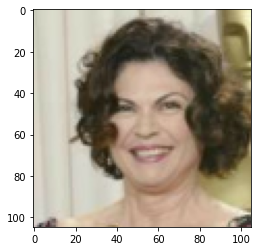

In [71]:
samples=data.as_numpy_iterator()
ex=samples.next()
print(ex[2])
plt.imshow(ex[1])